In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
import os 
os.chdir('gdrive/My Drive/Colab Notebooks')

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
!cat /proc/meminfo

In [ ]:
!pip install pdfplumber
!pip install nltk
!pip install -U gensim
!pip install flask-ngrok
!pip install werkzeug
!pip install numpy

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)


In [ ]:
def pdf_extract(file_name):
  import pdfplumber
  directory = "docs"
  pdf_txt = ""
  for file in os.listdir(directory):
      filename = os.fsdecode(file)
      if(filename == file_name):
          pdf_txt = '' # new line
          with pdfplumber.open(directory + '/' + filename) as pdf:
              for pdf_page in pdf.pages:
                single_page_text = pdf_page.extract_text()
                pdf_txt = pdf_txt + single_page_text
  return pdf_txt

In [ ]:
print(pdf_extract('iiitkota.pdf'))

IIIT Kota has been challenging and developing great minds for many years.
Characterised by a tradition of creating a center for imparting technical education of international standards, we are committed to excellence in education, to innovative practice and to the concept of lifelong learning.The Indian Institute of Information Technology Kota, deemed to be a Institute of National Importance, was established in 2013 with a vision to contribute the IT world through education and research, entrepreneurship and innovation.
IIIT Kota is a joint venture of the Ministry of Education (MoE) Govt. of India and Govt. of Rajasthan with Industry Partners in Public-Private-Partnership (PPP) mode.
Currently the institute is mentored by Malaviya National Institute of Technology Jaipur (MNIT Jaipur) and situated at MNIT Jaipur. The main site of IIIT, Kota shall be constructed at Ranpur near Kota on 100.37 acres of land made available by the Govt. of Rajasthan. The institute is governed by the eminent 

In [ ]:
import re
import gensim
from gensim.parsing.preprocessing import remove_stopwords

def clean_sentence(sentence, stopwords=False):
  sentence = sentence.lower().strip()
  sentence = re.sub(r'[^a-z0-9\s]', '', sentence)
  if stopwords:
    sentence = remove_stopwords(sentence)
  return sentence

def get_cleaned_sentences(tokens, stopwords=False):
  cleaned_sentences = []
  for row in tokens:
    cleaned = clean_sentence(row, stopwords)
    cleaned_sentences.append(cleaned)
  return cleaned_sentences

In [ ]:
def retrieveAndPrintFAQAnswer(question_embedding, sentence_embeddings, sentences):
  import sklearn
  from sklearn.metrics.pairwise import cosine_similarity
  max_sim = -1
  index_sim = -1
  for index, embedding in enumerate(sentence_embeddings):
    sim = cosine_similarity(embedding, question_embedding)[0][0]
    if sim > max_sim:
      max_sim = sim
      index_sim = index
  
  return index_sim

In [ ]:
def naive_drive(file_name, question):
  pdf_txt = pdf_extract(file_name)
  import nltk
  import numpy
  import pprint
  nltk.download('punkt')
  tokens = nltk.sent_tokenize(pdf_txt)
  cleaned_sentences = get_cleaned_sentences(tokens, stopwords=True)
  cleaned_sentences_with_stopwords = get_cleaned_sentences(tokens, stopwords=False)
  sentences = cleaned_sentences_with_stopwords
  sentence_words = [[word for word in document.split()]
                    for document in sentences]

  from gensim import corpora
  dictionary = corpora.Dictionary(sentence_words)
  bow_corpus = [dictionary.doc2bow(text) for text in sentence_words]

  question = clean_sentence(question, stopwords=False)
  question_embedding = dictionary.doc2bow(question.split())

  index = retrieveAndPrintFAQAnswer(question_embedding, bow_corpus, sentences)
  return sentences[index]

In [ ]:
question = "What were the various steps taken by the government to boost domestic and foreign investment in India ?"
answer = naive_drive('fdi.pdf', question)
print(answer)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


IndexError: ignored

===================================================================================================================

In [ ]:
from gensim.models import Word2Vec
import gensim.downloader as api

v2w_model = None
try:
  v2w_model = gensim.models.Keyedvectors.load('./w2vecmodel.mod')
  print("w2v Model Successfully loaded")
except:
  v2w_model = api.load('word2vec-google-news-300')
  v2w_model.save("./w2vecmodel.mod")
  print("w2v Model Saved")

w2vec_embedding_size = len(v2w_model['pc']) 

[==================================================] 100.0% 1662.8/1662.8MB downloaded
w2v Model Saved


In [ ]:
def getWordVec(word, model):
  import numpy
  samp = model['pc']
  vec = [0]*len(samp)
  try:
    vec = model[word]
  except:
    vec = [0]*len(samp)
  return (vec)


def getPhraseEmbedding(phrase, embeddingmodel):
  import numpy
  samp = getWordVec('computer', embeddingmodel)
  vec = numpy.array([0]*len(samp))
  den = 0;
  for word in phrase.split():
    den = den+1
    vec = vec+numpy.array(getWordVec(word, embeddingmodel))
  return vec.reshape(1, -1)

In [ ]:
def word2vec_drive(file_name, question):
  pdf_txt = pdf_extract(file_name)

  import nltk
  import numpy
  import pprint
  
  nltk.download('punkt')
  tokens = nltk.sent_tokenize(pdf_txt)
  cleaned_sentences = get_cleaned_sentences(tokens, stopwords=True)
  cleaned_sentences_with_stopwords = get_cleaned_sentences(tokens, stopwords=False)
  sentences = cleaned_sentences_with_stopwords
  sentence_words = [[word for word in document.split()]
                    for document in sentences]

  sent_embeddings = []
  for sent in sentences:
    sent_embeddings.append(getPhraseEmbedding(sent, v2w_model))

  question_embedding = getPhraseEmbedding(question, v2w_model)
  index = retrieveAndPrintFAQAnswer(question_embedding, sent_embeddings, cleaned_sentences_with_stopwords)
  return cleaned_sentences_with_stopwords[index]

In [ ]:
question = "What were the various steps taken by the government to boost domestic and foreign investment in India ?"
answer = word2vec_drive('fdi.pdf', question)
print(answer)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
recently government has taken various steps in addition to ongoing schemes to boost domestic 
and foreign investments in india


===================================================================================================================

In [ ]:
from gensim.models import Word2Vec
import gensim.downloader as api

glove_model = None
try:
  glove_model = gensim.models.Keyedvectors.load('./glovemodel.mod')
  print("Glove Model Successfully loaded")
except:
  glove_model = api.load('glove-twitter-25')
  glove_model.save("./glovemodel.mod")
  print("Glove Model Saved")

glove_embedding_size = len(glove_model['pc'])

[==================================================] 100.0% 104.8/104.8MB downloaded
Glove Model Saved


In [ ]:
def glove_drive(file_name, question):
  pdf_txt = pdf_extract(file_name)

  import nltk
  import numpy
  import pprint

  nltk.download('punkt')
  tokens = nltk.sent_tokenize(pdf_txt)
  cleaned_sentences = get_cleaned_sentences(tokens, stopwords=True)
  cleaned_sentences_with_stopwords = get_cleaned_sentences(tokens, stopwords=False)
  sentences = cleaned_sentences_with_stopwords
  sentence_words = [[word for word in document.split()]
                    for document in sentences]

  sent_embeddings = []
  for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent, glove_model))

  question_embedding = getPhraseEmbedding(question, glove_model)
  index = retrieveAndPrintFAQAnswer(question_embedding, sent_embeddings, cleaned_sentences_with_stopwords)
  return cleaned_sentences_with_stopwords[index]

In [ ]:
question = "What were the various steps taken by the government to boost domestic and foreign investment in India ?"
answer = glove_drive('fdi.pdf', question)
print(answer)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
as a result of the measures taken to improve the countrys investment climate india 
jumped to 63rd place in world banks ease of doing business ranking as per world banks doing 
business report dbr 2020


===================================================================================================================

In [ ]:
!pip install transformers==3.1.0
import torch
from transformers import BertForQuestionAnswering
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
  

In [ ]:
def answer_question_bert(question, answer_text):

    input_ids = tokenizer.encode(question, answer_text, max_length=512, truncation=True)

    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    sep_index = input_ids.index(tokenizer.sep_token_id)

    num_seg_a = sep_index + 1

    num_seg_b = len(input_ids) - num_seg_a

    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    assert len(segment_ids) == len(input_ids)

    start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))

    all_tokens = tokenizer.convert_ids_to_tokens(input_ids)

    #print(' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))
    #print(f'score: {torch.max(start_scores)}')
    score = float(torch.max(start_scores))
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    answer = tokens[answer_start]

    for i in range(answer_start + 1, answer_end + 1):

        if tokens[i][0:2] == '##':
          answer += tokens[i][2:]
        else:
          answer += ' ' + tokens[i]
        #if tokens[i][0:2] == ' ':
         #   answer += tokens[i][2:]

        #else:
           # answer += ' ' + tokens[i]
    return answer, score, start_scores, end_scores, tokens
    #print('Answer: "' + answer + '"')

In [ ]:
def expand_split_sentences(pdf_txt):
  import nltk
  nltk.download('punkt')
  new_chunks = nltk.sent_tokenize(pdf_txt)
  length = len(new_chunks)
  #for i in range(length):
    #tmp_token = tokenizer.encode(new_chunks[i])
    #print('The input has a total of {:} tokens.'.format(len(tmp_token)))

  new_df = [];
  for i in range(length):
    paragraph = ""
    for j in range(i, length):
      #tmp_str = paragraph + new_chunks[j]
      tmp_token = tokenizer.encode(paragraph + new_chunks[j])
      length_token = len(tmp_token)
      if length_token < 510:
        #print(length_token)
        paragraph = paragraph + new_chunks[j]
      else:
        #print(length_token)
        break;
    #print(len(tokenizer.encode(paragraph)))
    new_df.append(paragraph)
  return new_df
  #for i in new_df:
    #print(i)

In [ ]:
def bert_drive(file_name, question):
  import numpy
  text = pdf_extract(file_name)
  max_score = 0;
  final_answer = ""
  new_df = expand_split_sentences(text)
  tokens = []
  s_scores = numpy.array([])
  e_scores = numpy.array([])
  for new_context in new_df:
    #new_paragrapgh = new_paragrapgh + answer_question(question, answer_text)
    ans, score, start_score, end_score, token = answer_question_bert(question, new_context)
    if score > max_score:
      max_score = score
      s_scores = start_score.detach().numpy().flatten()
      e_scores = end_score.detach().numpy().flatten()
      tokens = token
      final_answer = ans
  return final_answer, s_scores, e_scores, tokens

In [ ]:
def draw_graph(s_scores, e_scores, tokens):
  import matplotlib.pyplot as plt
  import seaborn as sns

  sns.set(style='darkgrid')
  plt.rcParams["figure.figsize"] = (48,8)
  token_labels = []
  for (i, token) in enumerate(tokens):
      token_labels.append('{:} - {:>2}'.format(token, i))
  ax = sns.barplot(x=token_labels, y=s_scores, ci=None)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
  ax.grid(True)
  plt.title('Start Word Scores')
  plt.show()

  ax = sns.barplot(x=token_labels, y=e_scores, ci=None)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
  ax.grid(True)
  plt.title('End Word Scores')
  plt.show()

  import pandas as pd
  scores = []
  for (i, token_label) in enumerate(token_labels):
      scores.append({'token_label': token_label, 
                    'score': s_scores[i],
                    'marker': 'start'})
      scores.append({'token_label': token_label, 
                    'score': e_scores[i],
                    'marker': 'end'})
  df = pd.DataFrame(scores)
  g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=9, aspect=7)
  g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")
  g.ax.grid(True)

In [ ]:
question = "How many courses in iiitkota has?"
answer, s_scores, e_scores, tokens = bert_drive('iiitkota.pdf', question)
print(answer)
draw_graph(s_scores, e_scores, tokens)

TypeError: ignored

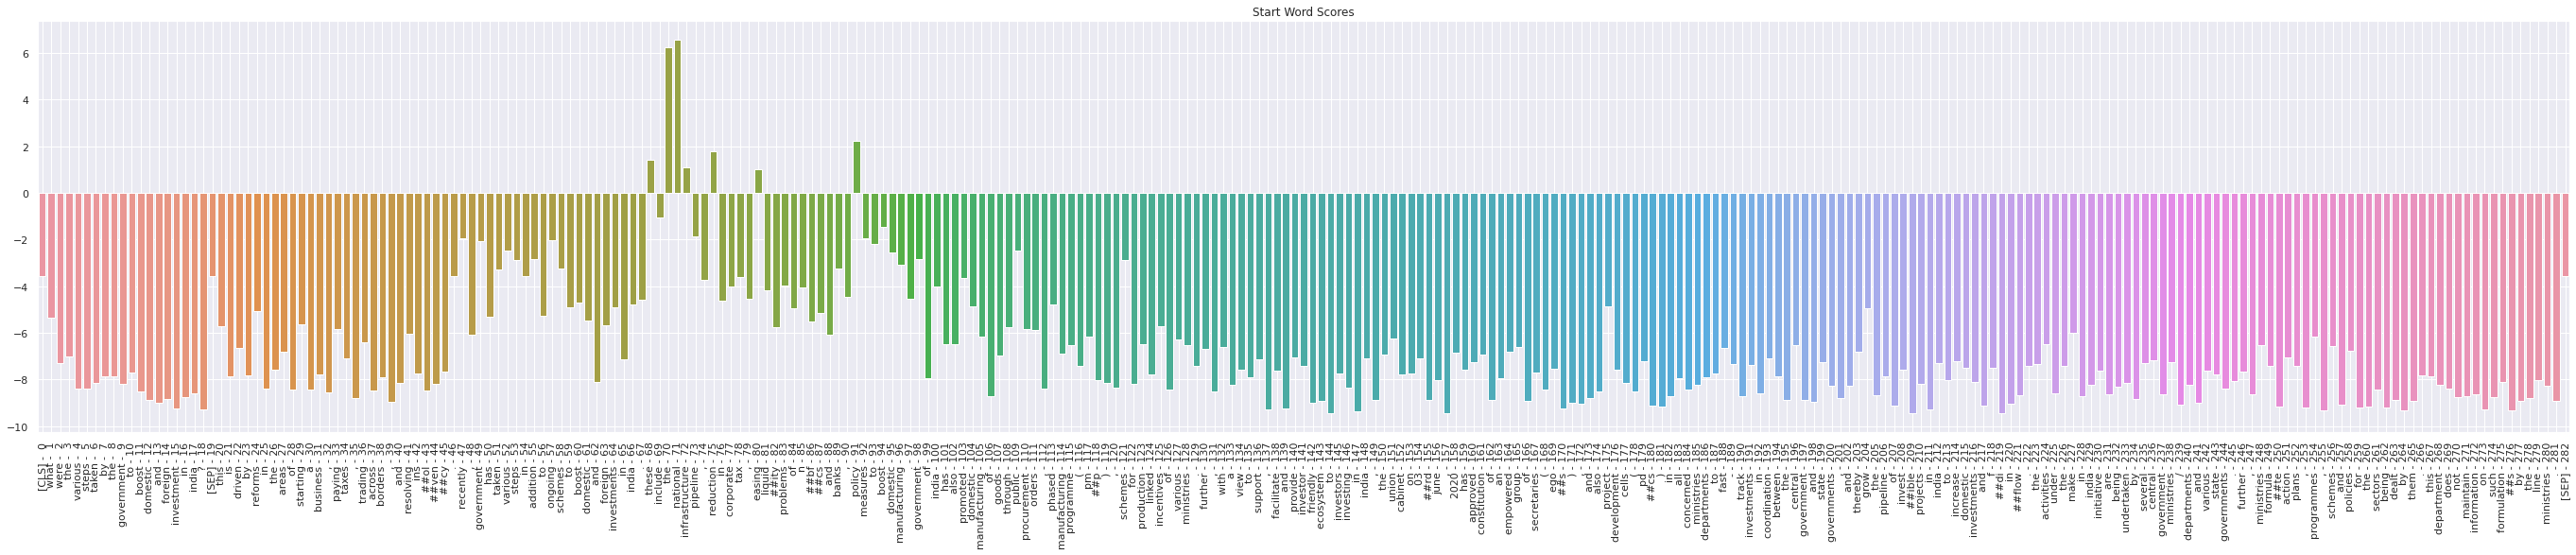

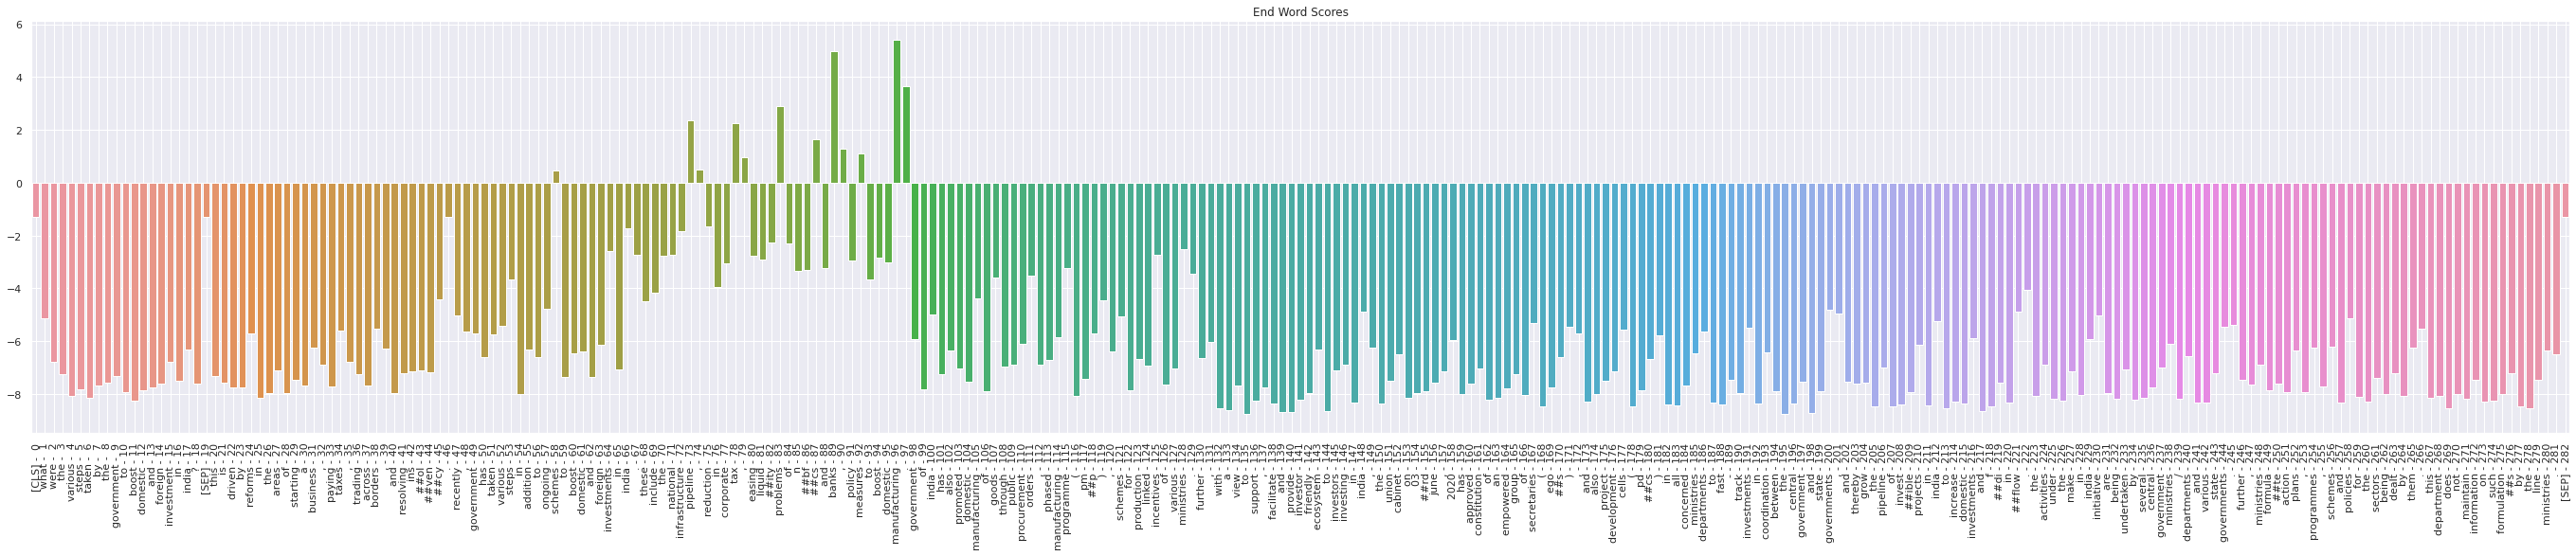

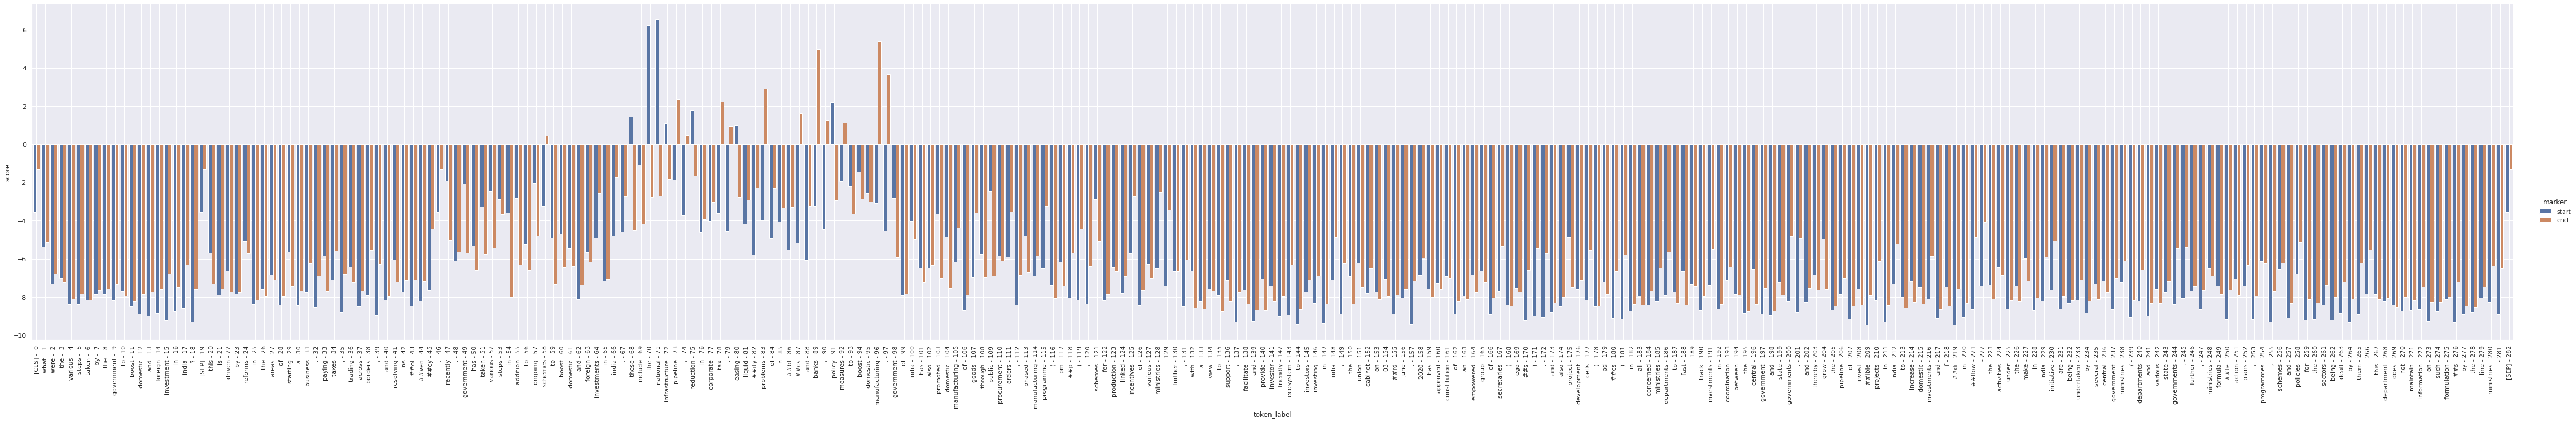

In [ ]:
draw_graph(s_scores, e_scores, tokens)

===================================================================================================================

In [ ]:
!pip install cdqa

     |████████████████████████████████| 51kB 3.1MB/s 
     |████████████████████████████████| 102kB 5.7MB/s 
     |████████████████████████████████| 286kB 43.4MB/s 
     |████████████████████████████████| 10.4MB 51.3MB/s 
     |████████████████████████████████| 317kB 53.2MB/s 
     |████████████████████████████████| 6.7MB 20.3MB/s 
     |████████████████████████████████| 748.9MB 19kB/s 
     |████████████████████████████████| 92kB 11.2MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 901kB 41.3MB/s 
     |████████████████████████████████| 1.2MB 47.2MB/s 
     |████████████████████████████████| 133kB 58.0MB/s 
     |████████████████████████████████| 7.5MB 42.7MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
  Created wheel for cdqa: filename=cdqa-1.3.9-cp37-none-any.whl size=47640 sha256=d5a4f1e8d5d79223e116065774dba191389b06334f5be45d2a0336c864360287
  Stored in directory: /root/.cache/pip/wheels/8b/9a/68/d3f7651ea29c30d1bebc

In [ ]:
import os
import pandas as pd
from ast import literal_eval

from cdqa.utils.converters import pdf_converter
from cdqa.pipeline import QAPipeline
from cdqa.utils.download import download_model
download_model(model='bert-squad_1.1', dir='./models')
!pip install pandas==1.1.0

/usr/local/lib/python3.7/dist-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)



bert_qa.joblib already downloaded
     |████████████████████████████████| 10.5MB 4.3MB/s 
ERROR: fbprophet 0.7.1 has requirement tqdm>=4.36.1, but you'll have tqdm 4.32.2 which is incompatible.
ERROR: cdqa 1.3.9 has requirement pandas==0.25.0, but you'll have pandas 1.1.0 which is incompatible.
  Found existing installation: pandas 0.25.0
    Uninstalling pandas-0.25.0:
      Successfully uninstalled pandas-0.25.0


In [ ]:
def fine_tuning_drive(question):
  df = pdf_converter(directory_path="docs/")
  pd.set_option('display.max_colwidth', -1)
  df.head()
  cdqa_pipeline = QAPipeline(reader='./models/bert_qa.joblib', max_df=1.0)
  cdqa_pipeline.fit_retriever(df=df)
  import joblib
  joblib.dump(cdqa_pipeline, './models/bert_qa_custom.joblib')
  cdqa_pipeline=joblib.load('./models/bert_qa_custom.joblib')
  prediction = cdqa_pipeline.predict(question, 1)
  return prediction

In [ ]:
question = "What were the various steps taken by the government to boost domestic and foreign investment in India ?"
print(fine_tuning_drive(question))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


[('the National Infrastructure Pipeline, Reduction in Corporate Tax, easing liquidity problems of NBFCs and Banks', 'fdi', 'Recently, Government has taken various steps in addition to ongoing schemes to boost domestic and foreign investments in India. These include the National Infrastructure Pipeline, Reduction in Corporate Tax, easing liquidity problems of NBFCs and Banks, policy measures to boost domestic manufacturing. Government of India has also promoted domestic manufacturing of goods through public procurement orders, Phased Manufacturing Programme (PMP), Schemes for Production Linked Incentives of various Ministries. ', 8.688585496665787)]


===================================================================================================================

In [ ]:
question = "What were the various steps taken by the government to boost domestic and foreign investment in India ?"
answer = naive_drive('fdi.pdf', question)
print(answer)
answer = word2vec_drive('fdi.pdf', question)
print(answer)
answer = glove_drive('fdi.pdf', question)
print(answer)
answer = (bert_drive('fdi.pdf', question)
print(answer)
answer = fine_tuning_drive(question)
print(answer)

In [ ]:
from flask import *
from flask_ngrok import run_with_ngrok
from werkzeug.utils import secure_filename
from werkzeug.datastructures import  FileStorage

app = Flask(__name__)
run_with_ngrok(app)
@app.route('/', methods=['GET', 'POST'])
def index():
  if request.method == 'POST':
    if(request.form.get('btn') == 'index'):
      upload = request.files['upload']
      path = "docs"
      global file_name
      file_name = upload.filename
      print(file_name)
      upload.save(os.path.join(path, secure_filename(upload.filename)))
      return redirect(url_for('qa'))
    elif (request.form.get('btn') == 'qa'):
      question = request.form.get('question')
      answer = ""
      if(func == 'naive'):
        answer = naive_drive(file_name, question)
      elif(func == 'w2v'):
        answer = word2vec_drive(file_name, question)
      elif(func == 'glove'):
        answer = glove_drive(file_name, question)
      elif(func == 'bert'):
        answer, s_scores, e_scores, tokens = bert_drive(file_name, question)
        draw_graph(s_scores, e_scores, tokens)
      else:
        answer = fine_tuning_drive(question)
      #answer = fine_tuning_drive(question)
      print(answer)
      return render_template('qa.html', answer = answer, question = question)
  return render_template('index.html')
@app.route('/upload/', methods=['GET', 'POST'])
def upload():
    global func
    func = request.args.get('type')
    return render_template('upload.html')

@app.route('/qa/', methods=['GET', 'POST'])
def qa():
    return render_template('qa.html')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://a1419954cc6c.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [23/May/2021 07:21:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2021 07:21:58] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [23/May/2021 07:21:58] "GET /upload/?type=bert HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2021 07:22:05] "POST / HTTP/1.1" 302 -


iiitkota.pdf


127.0.0.1 - - [23/May/2021 07:22:05] "GET /qa/ HTTP/1.1" 200 -
Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Query has 442 tokens.

Query has 428 tokens.

Query has 470 tokens.

Query has 453 tokens.

Query has 448 tokens.

Query has 431 tokens.

Query has 404 tokens.

Query has 375 tokens.

Query has 372 tokens.

Query has 356 tokens.

Query has 335 tokens.

Query has 295 tokens.

Query has 263 tokens.

Query has 229 tokens.

Query has 211 tokens.

Query has 186 tokens.

Query has 167 tokens.

Query has 150 tokens.

Query has 129 tokens.



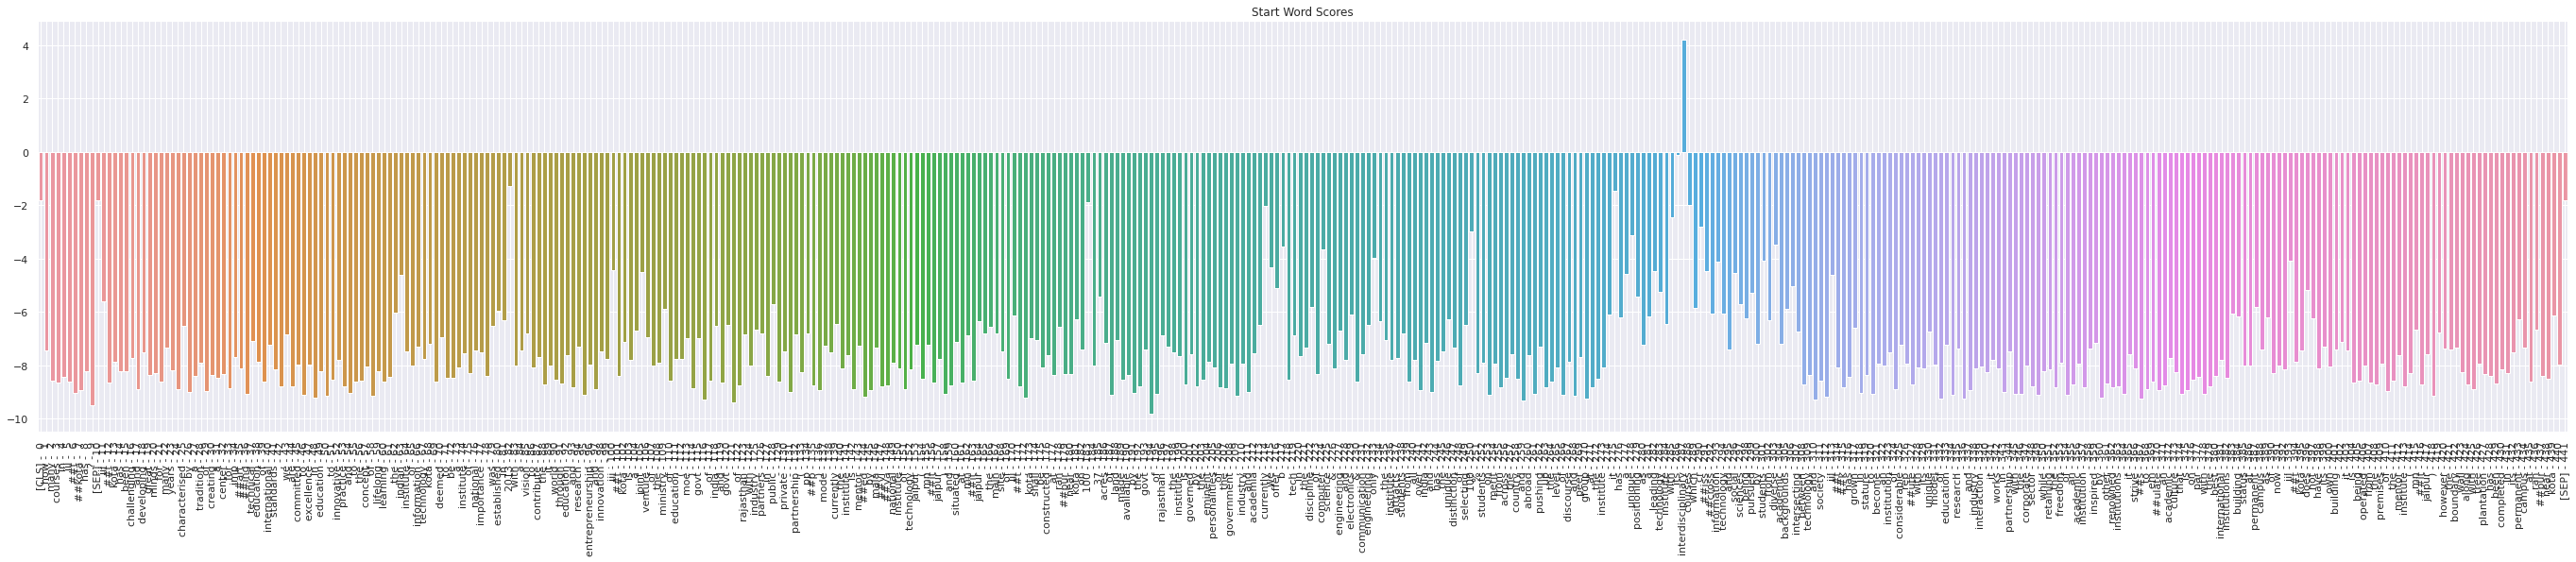

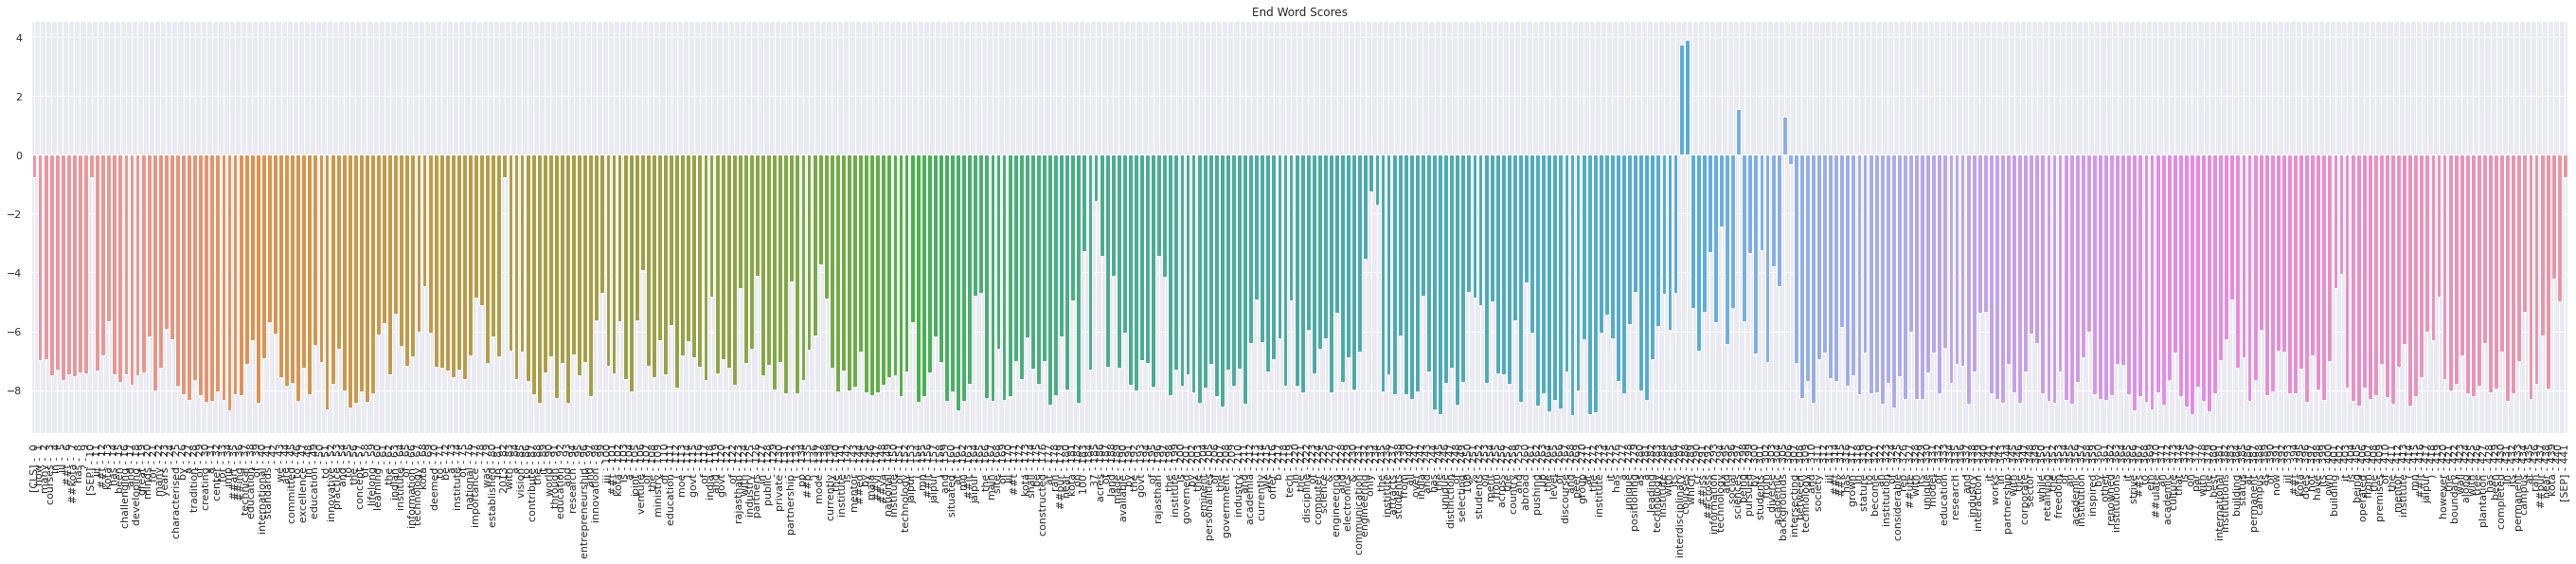

127.0.0.1 - - [23/May/2021 07:24:20] "POST / HTTP/1.1" 200 -


interdisciplinary courses


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Query has 443 tokens.

Query has 429 tokens.

Query has 471 tokens.

Query has 454 tokens.

Query has 449 tokens.

Query has 432 tokens.

Query has 405 tokens.

Query has 376 tokens.

Query has 373 tokens.

Query has 357 tokens.

Query has 336 tokens.

Query has 296 tokens.

Query has 264 tokens.

Query has 230 tokens.

Query has 212 tokens.

Query has 187 tokens.

Query has 168 tokens.

Query has 151 tokens.

Query has 130 tokens.



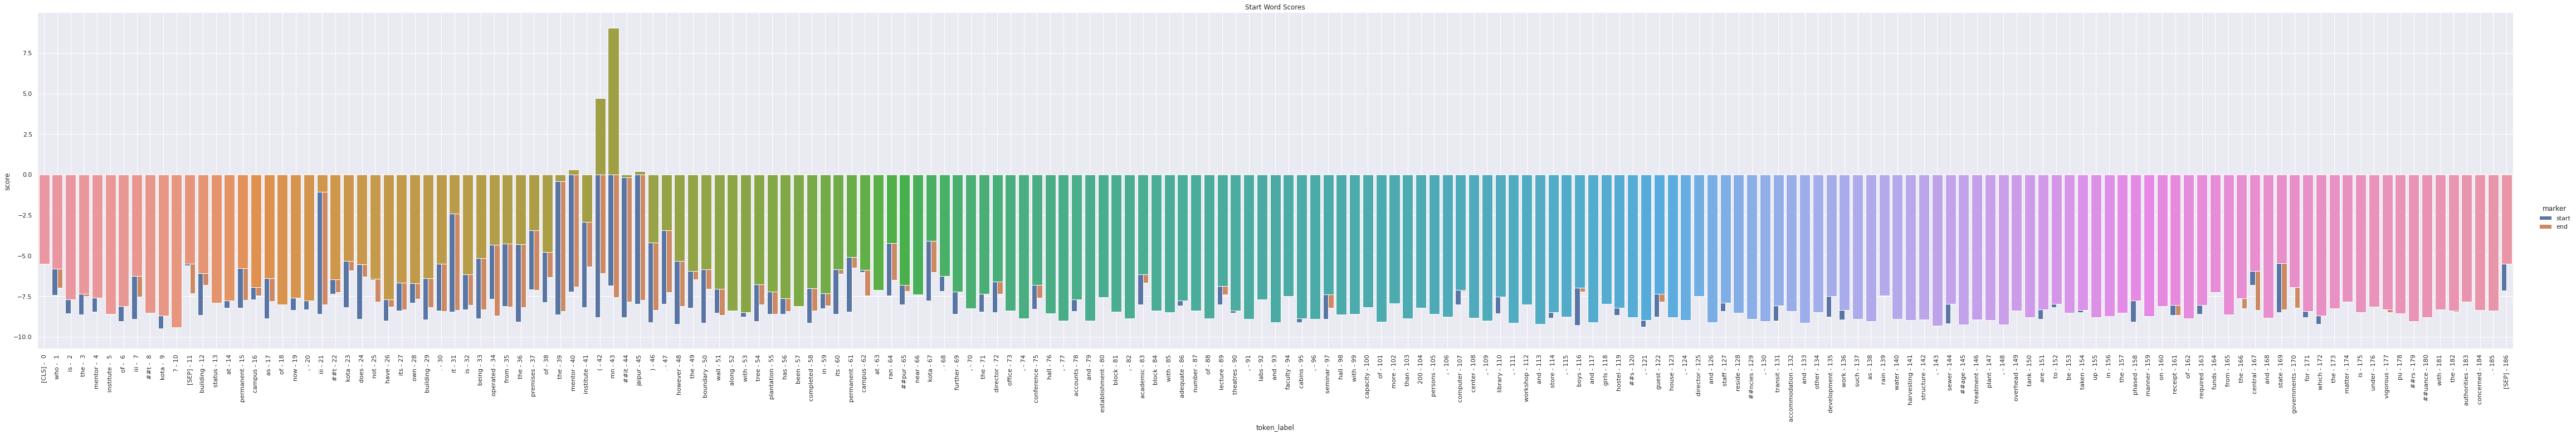

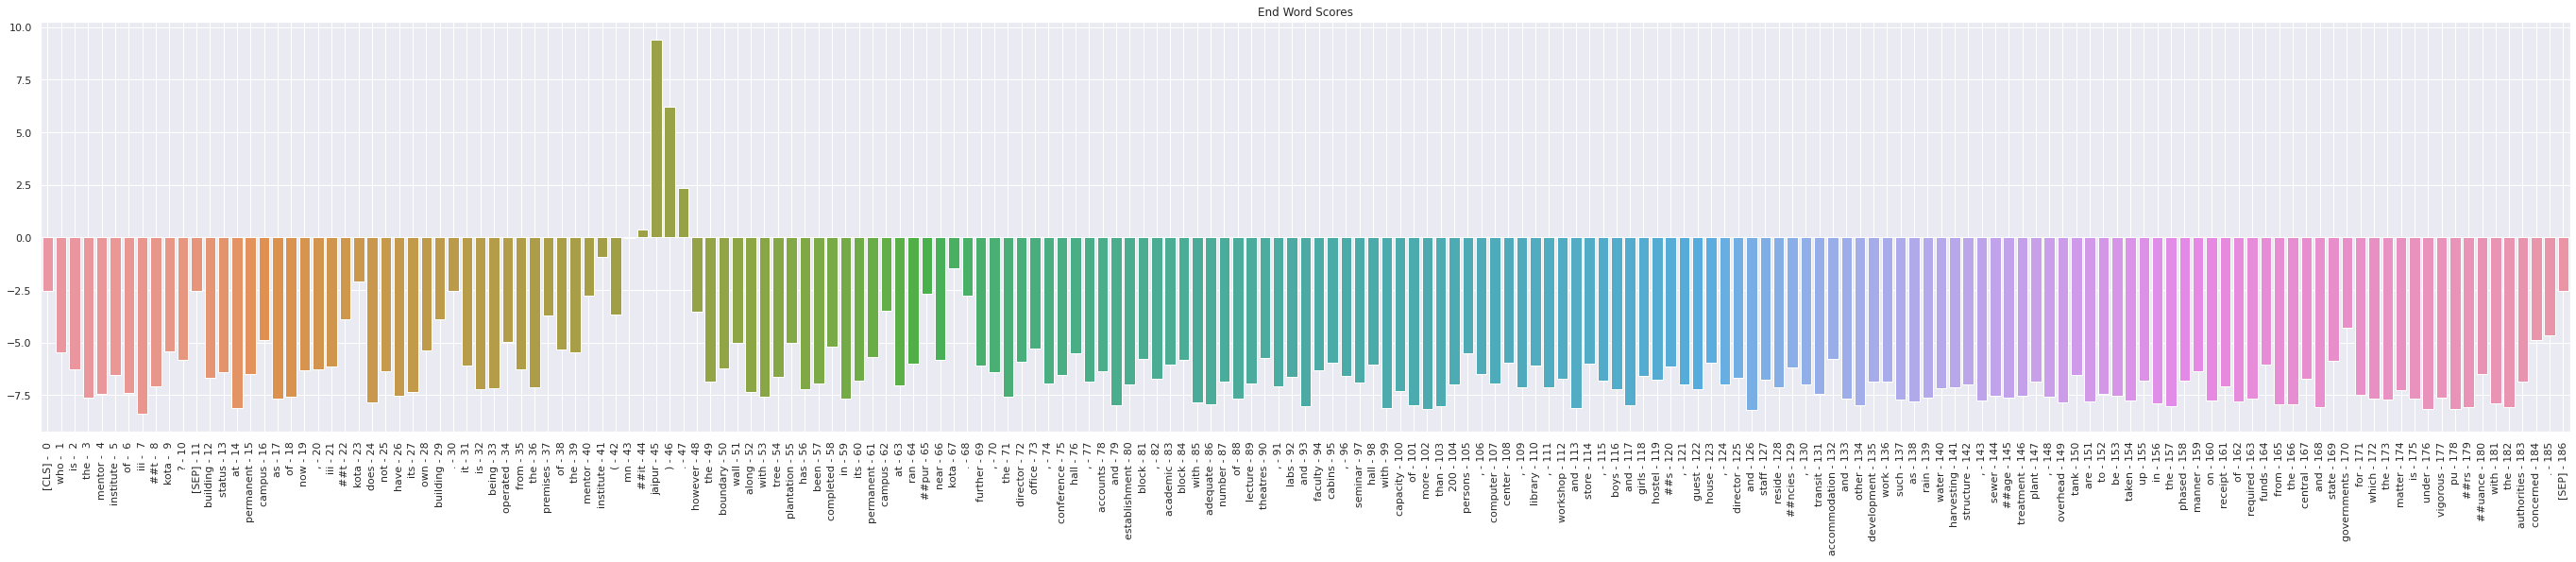

127.0.0.1 - - [23/May/2021 07:27:09] "POST / HTTP/1.1" 200 -


mnit jaipur
Error in callback <function flush_figures at 0x7f562c48a3b0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
app.run()